In [1]:
import networkx as nx
from netwulf import visualize
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib import font_manager
font_manager.fontManager.addfont("./images/times.ttf")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

%pwd

'/home/cseadmin/dz/DL-Traff-Graph/workSZTAXI-dz'

In [2]:
df_edges=gpd.read_file("../../TrafficFlowModel/data/sz_taxi_202006/fmm_sz_taxi_202006/edges.shp")

df_edges

,fid,u,v,geometry
0,0,39,105,"LINESTRING (114.04424 22.55066, 114.04424 22.5..."
1,1,129,36,"LINESTRING (114.04761 22.55094, 114.04768 22.5..."
2,2,36,68,"LINESTRING (114.04768 22.54928, 114.04667 22.5..."
3,3,68,10,"LINESTRING (114.04667 22.54928, 114.04665 22.5..."
4,4,39,10,"LINESTRING (114.04424 22.55066, 114.04665 22.5..."
...,...,...,...,...
487,487,79,45,"LINESTRING (114.06304 22.53372, 114.06297 22.5..."
488,488,73,79,"LINESTRING (114.06305 22.53176, 114.06304 22.5..."
489,489,102,79,"LINESTRING (114.06133 22.53171, 114.06304 22.5..."
490,490,102,73,"LINESTRING (114.06133 22.53171, 114.06305 22.5..."


In [3]:
df_rel=pd.read_csv("../../TrafficFlowModel/data/sz_taxi_202006/sz_taxi_202006.rel")

df_rel

,rel_id,type,origin_id,destination_id
0,0,geo,0,70
1,1,geo,0,246
2,2,geo,0,252
3,3,geo,1,2
4,4,geo,1,63
...,...,...,...,...
1689,1689,geo,490,244
1690,1690,geo,490,488
1691,1691,geo,491,245
1692,1692,geo,491,489


In [4]:
road_list=[233, 238, 245, 242, 243, 244, 239]
# road_list=[228, 226, 230, 229, 231, 232, 233]

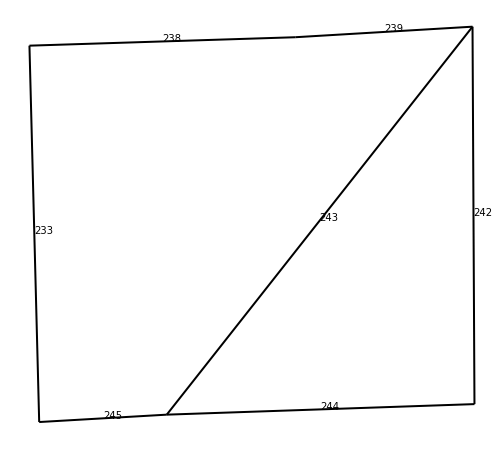

In [95]:
df_plot=df_edges.iloc[road_list]
ax=df_plot.plot(color="black", linewidth=2, linestyle="-", figsize=(12, 8))
ax.set_axis_off()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")

# plt.savefig("./images/road_correlation.png", dpi=300, bbox_inches="tight")
plt.show(); # 箭头不好画，这张图直接手绘箭头

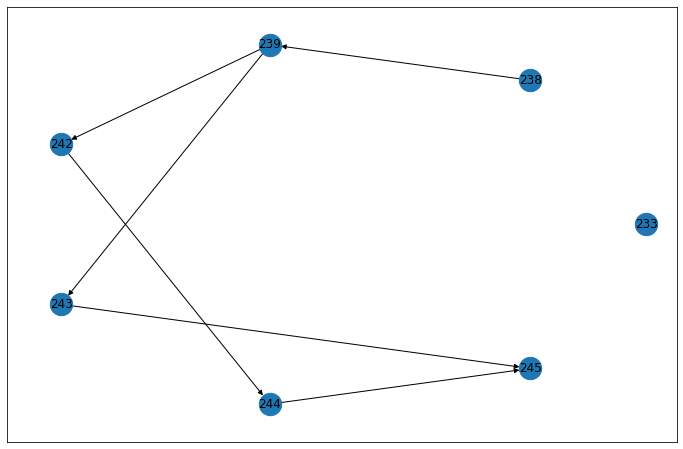

In [5]:
basic_graph=nx.DiGraph()
basic_graph.add_nodes_from(range(246))

for _, row in df_rel.iterrows():
    o=row.origin_id
    d=row.destination_id
    # o=row.origin_id if row.origin_id<246 else row.origin_id-246
    # d=row.destination_id if row.destination_id<246 else row.destination_id-246
    if o==d:
        continue
    basic_graph.add_edge(o, d)

subgraph_adj=basic_graph.subgraph(road_list)
# pos=nx.spring_layout(subgraph_adj)
pos=nx.circular_layout(subgraph_adj)

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph_adj, node_size=500, with_labels=True, pos=pos);

In [13]:
visualize(basic_graph)

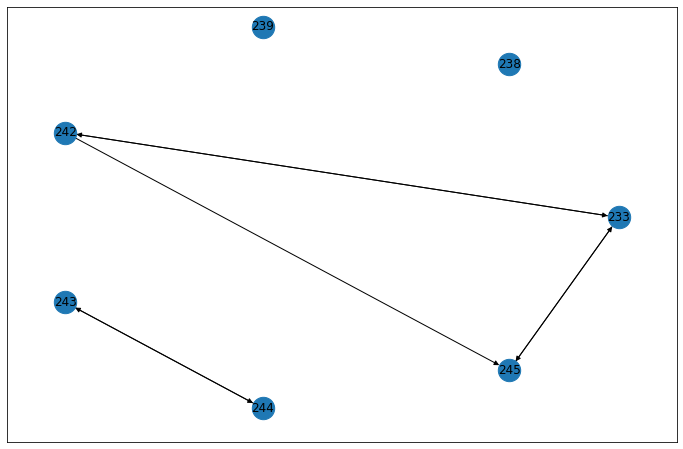

In [46]:
adj_k = np.load("../SZTAXI/adj_20.npy")

adj_k_graph = nx.DiGraph()
adj_k_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if adj_k[i, j]!=0:
            adj_k_graph.add_edge(i, j, weight=adj_k[i, j])
        # if adj_k[i+246, j]!=0:
        #     adj_k_graph.add_edge(i, j, weight=adj_k[i+246, j])
        # if adj_k[i, j+246]!=0:
        #     adj_k_graph.add_edge(i, j, weight=adj_k[i, j+246])
        # if adj_k[i+246, j+246]!=0:
        #     adj_k_graph.add_edge(i, j, weight=adj_k[i+246, j+246])

plt.figure(figsize=(12, 8))
nx.draw_networkx(adj_k_graph, node_size=500, with_labels=True, pos=pos)
plt.show();

In [33]:
def softmax(x):
    """ softmax function """
    
    # assert(len(x.shape) > 1, "dimension must be larger than 1")
    # print(np.max(x, axis = 1, keepdims = True)) # axis = 1, 行
    
    x_cp = x.copy()
    x_cp -= np.max(x, axis = 1, keepdims = True) #为了稳定地计算softmax概率， 一般会减掉最大的那个元素
    x_cp = np.exp(x_cp) / np.sum(np.exp(x_cp), axis = 1, keepdims = True)
    
    return x_cp

def relu(x):
    x[x<0]=0
    
    return x

In [7]:
from sklearn.preprocessing import MinMaxScaler
cor=np.load("../SZTAXI/cor_matrix.npy")

cor[np.diag_indices_from(cor)]=0
cor=MinMaxScaler().fit_transform(cor.T).T
cor[np.diag_indices_from(cor)]=1

# cor[np.diag_indices_from(cor)]=0
# cor=relu(cor)
# cor=softmax(cor)
# cor[np.diag_indices_from(cor)]=1

cor

array([[1.        , 0.4786337 , 0.6966655 , ..., 0.396482  , 0.6663878 ,
        0.48536363],
       [0.49207893, 1.        , 0.35265756, ..., 0.43834767, 0.62276953,
        0.49911582],
       [0.66114336, 0.31204852, 1.        , ..., 0.33605027, 0.5632547 ,
        0.45121023],
       ...,
       [0.37678337, 0.4064558 , 0.35071367, ..., 1.        , 0.50155115,
        0.46250996],
       [0.6593773 , 0.5962844 , 0.5907714 , ..., 0.51809645, 1.        ,
        0.47740674],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

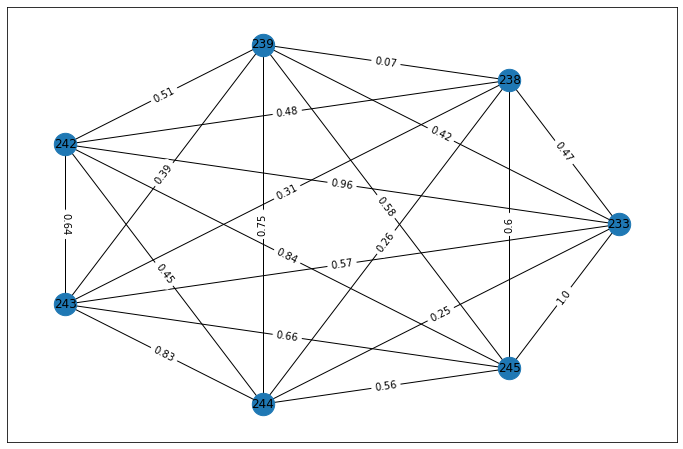

In [10]:
cor_graph=nx.Graph()
cor_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if cor[i, j]>0:
            cor_graph.add_edge(i, j, weight=cor[i, j])
            
edge_labels = dict([((u, v,), round(d["weight"], 2)) for u, v, d in cor_graph.edges(data=True)])

plt.figure(figsize=(12, 8))
nx.draw_networkx(cor_graph, node_size=500, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(cor_graph, pos, edge_labels=edge_labels)
plt.show();

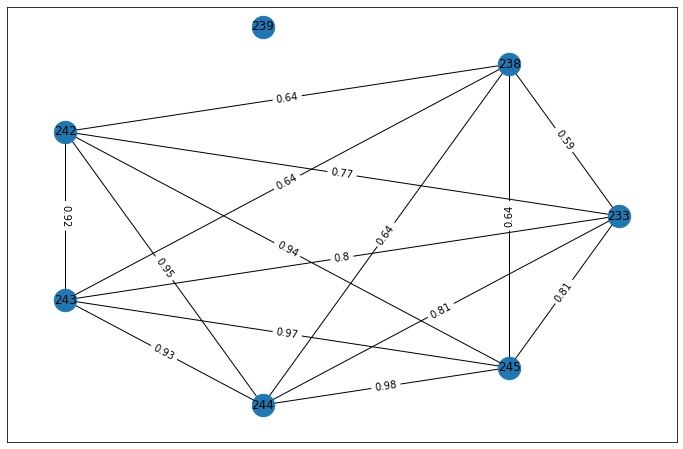

In [13]:
cos = np.load("../SZTAXI/flow_cosine.npy")

cos_graph = nx.Graph()
cos_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if cos[i, j]>0:
            cos_graph.add_edge(i, j, weight=cos[i, j])
            
edge_labels = dict([((u, v,), round(d["weight"], 2)) for u, v, d in cos_graph.edges(data=True)])

plt.figure(figsize=(12, 8))
nx.draw_networkx(cos_graph, node_size=500, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(cos_graph, pos, edge_labels=edge_labels)
plt.show();

In [11]:
edge_labels

{(233, 238): 0.59,
 (233, 245): 0.81,
 (233, 242): 0.77,
 (233, 243): 0.8,
 (233, 244): 0.81,
 (238, 245): 0.64,
 (238, 242): 0.64,
 (238, 243): 0.64,
 (238, 244): 0.64,
 (245, 242): 0.94,
 (245, 243): 0.97,
 (245, 244): 0.98,
 (242, 243): 0.92,
 (242, 244): 0.95,
 (243, 244): 0.93}

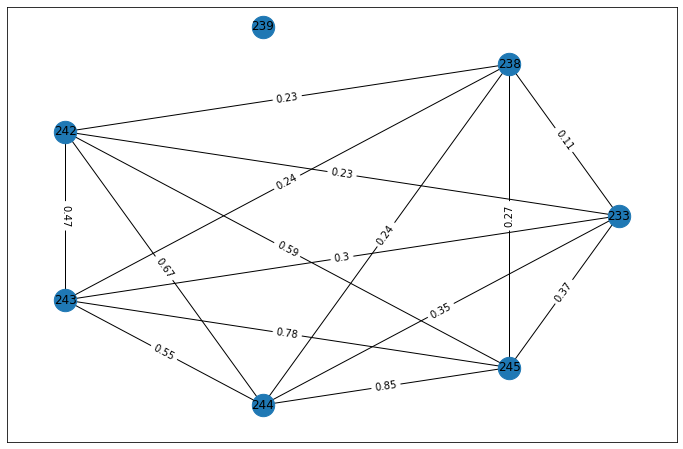

In [84]:
p = np.load("../SZTAXI/flow_pearson.npy")

p_graph = nx.Graph()
p_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if p[i, j]>0:
            p_graph.add_edge(i, j, weight=p[i, j])
            
edge_labels = dict([((u, v,), round(d["weight"], 2)) for u, v, d in p_graph.edges(data=True)])

plt.figure(figsize=(12, 8))
nx.draw_networkx(p_graph, node_size=500, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(p_graph, pos, edge_labels=edge_labels)
plt.show();

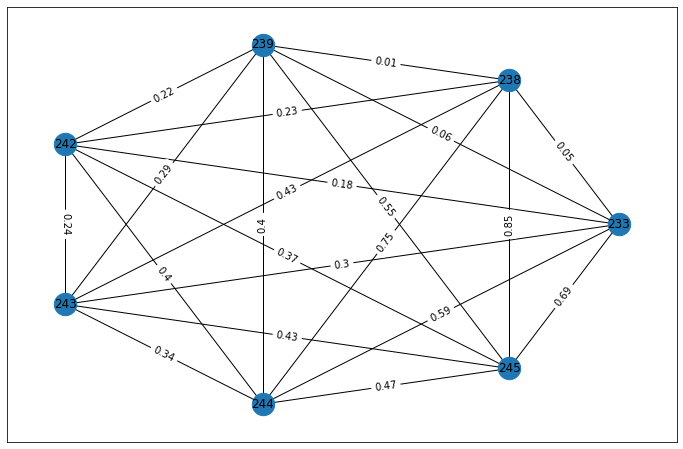

In [8]:
dtw = np.load("../SZTAXI/flow_DTW.npy")
dtw=MinMaxScaler().fit_transform(dtw.T).T

dtw_graph = nx.Graph()
dtw_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if dtw[i, j]>0:
            dtw_graph.add_edge(i, j, weight=dtw[i, j])
            
edge_labels = dict([((u, v,), round(d["weight"], 2)) for u, v, d in dtw_graph.edges(data=True)])

plt.figure(figsize=(12, 8))
nx.draw_networkx(dtw_graph, node_size=500, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(dtw_graph, pos, edge_labels=edge_labels)
plt.show();

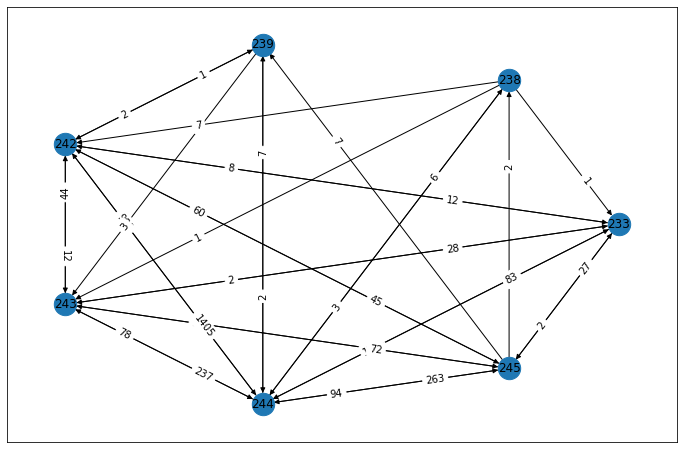

In [19]:
od = np.load("../SZTAXI/OD_matrix.npy")
# od=MinMaxScaler().fit_transform(od.T).T

od_graph = nx.DiGraph()
od_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if od[i, j]>0:
            od_graph.add_edge(i, j, weight=od[i, j])
            
edge_labels = dict([((u, v,), int(d["weight"])) for u, v, d in od_graph.edges(data=True)])

plt.figure(figsize=(12, 8))
nx.draw_networkx(od_graph, node_size=500, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(od_graph, pos, edge_labels=edge_labels, label_pos=0.3)
plt.show();

In [17]:
edge_labels

{(233, 245): 2,
 (233, 242): 8,
 (233, 243): 2,
 (233, 244): 15,
 (238, 233): 1,
 (238, 242): 7,
 (238, 243): 1,
 (238, 244): 3,
 (245, 233): 27,
 (245, 238): 2,
 (245, 242): 60,
 (245, 243): 24,
 (245, 244): 94,
 (245, 239): 7,
 (242, 233): 12,
 (242, 245): 45,
 (242, 243): 12,
 (242, 244): 1405,
 (242, 239): 1,
 (243, 233): 28,
 (243, 245): 72,
 (243, 242): 44,
 (243, 244): 237,
 (244, 233): 83,
 (244, 238): 6,
 (244, 245): 263,
 (244, 242): 901,
 (244, 243): 78,
 (244, 239): 7,
 (239, 242): 2,
 (239, 243): 3,
 (239, 244): 2}

---

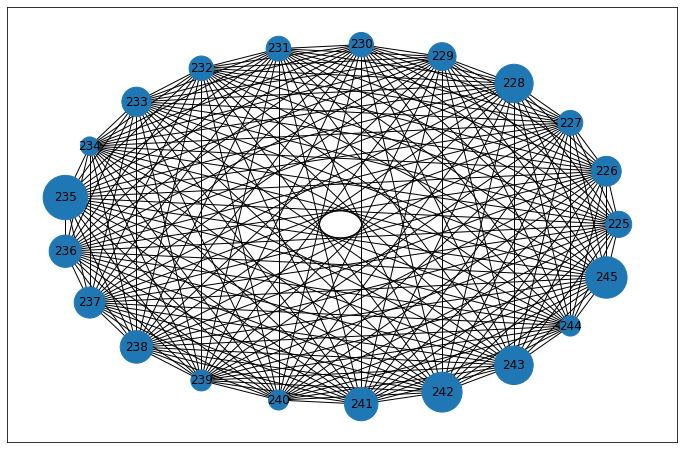

In [40]:
road_list=list(range(225, 246))

cor_graph=nx.Graph()
cor_graph.add_nodes_from(road_list)

for i in road_list:
    for j in road_list:
        if i==j:
            continue
        if cor[i, j]>0:
            cor_graph.add_edge(i, j, weight=cor[i, j])
            
node_size=np.sum(cor, axis=1)[225:246]
node_size=np.power(15, node_size/100)
            
plt.figure(figsize=(12, 8))
pos=nx.circular_layout(cor_graph)
nx.draw_networkx(cor_graph, node_size=node_size, with_labels=True, pos=pos)
plt.show();

In [37]:
node_size=np.sum(cor, axis=1)[225:246]
np.power(15, node_size/100)

array([ 679.6945 ,  886.0616 ,  615.4471 , 1472.2112 ,  776.79364,
        595.324  ,  613.3411 ,  600.0555 ,  852.8178 ,  340.4538 ,
       1962.8226 , 1042.3811 ,  963.8851 , 1056.6815 ,  439.21542,
        395.55133, 1113.5363 , 1595.3616 , 1482.4381 ,  414.1139 ,
       1715.3932 ], dtype=float32)

---

In [2]:
from sklearn.preprocessing import MinMaxScaler
embedding_matrix=np.load("../../TrafficFlowModel/model/saved/embedding_matrix.npy")

cor_matrix=embedding_matrix @ embedding_matrix.T
for i in range(len(cor_matrix)):
    cor_matrix[i][i]=0

scaler=MinMaxScaler()
cor_matrix=scaler.fit_transform(cor_matrix.T).T

for i in range(len(cor_matrix)):
    cor_matrix[i][i]=1
    
cor_matrix

array([[1.        , 0.4786337 , 0.6966655 , ..., 0.396482  , 0.6663878 ,
        0.48536363],
       [0.49207893, 1.        , 0.35265756, ..., 0.43834767, 0.62276953,
        0.49911582],
       [0.66114336, 0.31204852, 1.        , ..., 0.33605027, 0.5632547 ,
        0.45121023],
       ...,
       [0.37678337, 0.4064558 , 0.35071367, ..., 1.        , 0.50155115,
        0.46250996],
       [0.6593773 , 0.5962844 , 0.5907714 , ..., 0.51809645, 1.        ,
        0.47740674],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

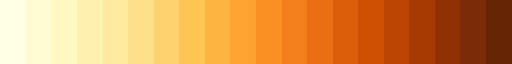

In [4]:
colormap=plt.cm.get_cmap("YlOrBr", 20)

colormap

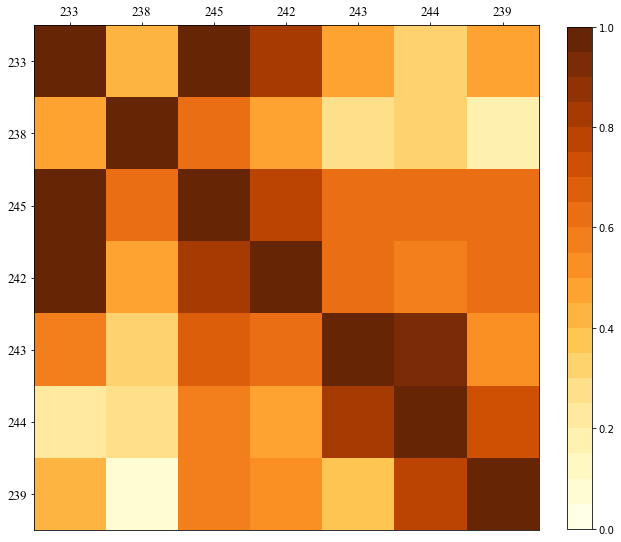

In [14]:
cor_matrix_sub=cor_matrix[np.ix_(road_list, road_list)]

plt.figure(figsize=(10, 10))
plt.imshow(cor_matrix_sub, cmap=colormap, vmin=0, vmax=1)
plt.xticks(range(len(road_list)), list(map(str, road_list)), fontproperties = "Times New Roman", size = 13)
plt.yticks(range(len(road_list)), list(map(str, road_list)), fontproperties = "Times New Roman", size = 13)
plt.gca().xaxis.set_ticks_position("top")
plt.colorbar(fraction=0.045)
# plt.savefig("./images/heatmap.png", dpi=300, bbox_inches="tight")
plt.show();

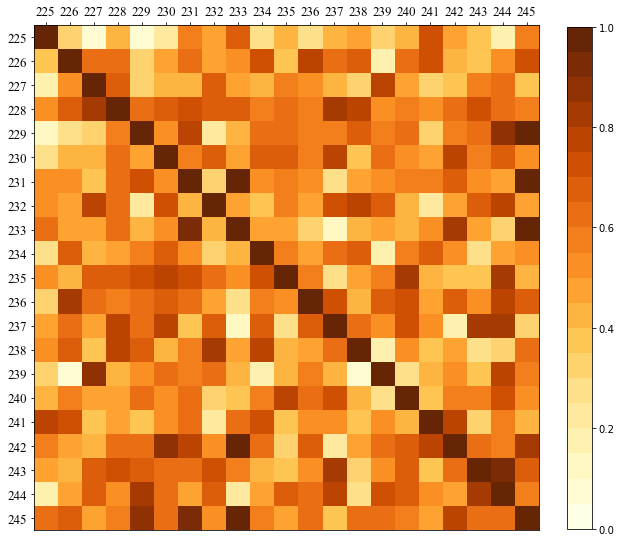

In [16]:
start=225
end=246
cor_matrix_sub=cor_matrix[start:end, start:end]

plt.figure(figsize=(10, 10))
plt.imshow(cor_matrix_sub, cmap=colormap, vmin=0, vmax=1)
plt.xticks(range(end-start), list(map(str, range(start, end))), fontproperties = "Times New Roman", size = 13)
plt.yticks(range(end-start), list(map(str, range(start, end))), fontproperties = "Times New Roman", size = 13)
plt.gca().xaxis.set_ticks_position("top")
plt.colorbar(fraction=0.045)
# plt.savefig("./images/heatmap.png", dpi=300, bbox_inches="tight")
plt.show();

In [42]:
np.argsort(cor_matrix_sub.sum(axis=1))[::-1]+225

array([228, 245, 242, 236, 243, 235, 231, 244, 230, 229, 237, 232, 226,
       240, 238, 233, 241, 234, 227, 239, 225])

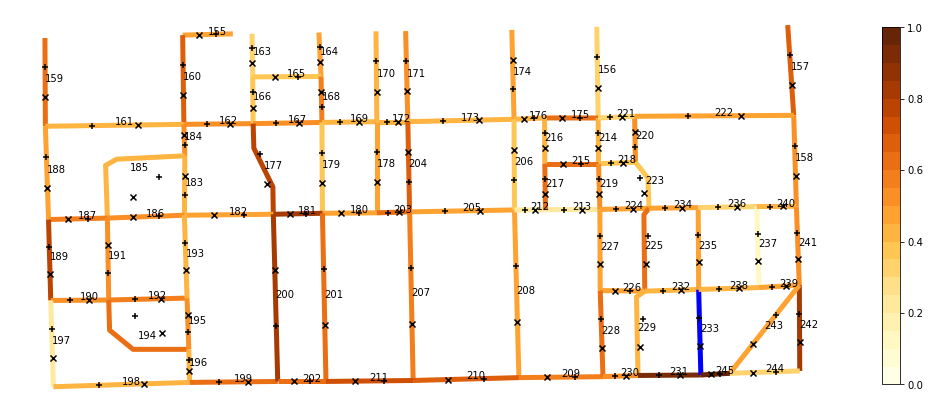

In [7]:
DATA_PATH = "../../TrafficFlowModel/data/"
TAXI_DATA_PATH = "../../TrafficFlowModel/data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

def get_color(row):
    row["color"]=colormap(row.cor)
    return row

n=233
df_edges["cor"]=cor_matrix[n]
df_edges=df_edges.apply(get_color, axis=1)
df_edges.at[n, "color"]=(0, 0, 1, 1)

df_plot=df_edges[155:246]#.append(df_edges[155+246:246+246])

ax=df_plot.plot(color=df_plot.color, linewidth=5, figsize=(16, 9))
norm = plt.Normalize(vmin=0, vmax=1)
n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, fraction=0.02)
ax.set_axis_off()
# ax.plot()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")
    
for index, row in df_plot.iterrows():
    l=len(row.geometry.coords)
    ls=np.linspace(row.geometry.coords[0], row.geometry.coords[-1], 4)
    s = ls[1]
    e = ls[2]
    plt.scatter(s[0], s[1], marker='+', color='black', zorder=2)
    plt.scatter(e[0], e[1], marker='x', color='black', zorder=2)

# plt.savefig("./images/road_correlation.png", dpi=300, bbox_inches="tight")
plt.show();

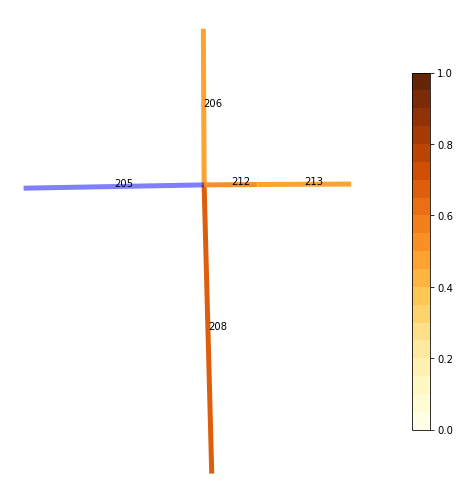

In [37]:
# case 2: 205 右拐进入 208 深圳会展中心内部道路

DATA_PATH = "../../TrafficFlowModel/data/"
TAXI_DATA_PATH = "../../TrafficFlowModel/data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

def get_color(row):
    row["color"]=colormap(row.cor)
    return row

df_edges["cor"]=cor_matrix[n]
df_edges=df_edges.apply(get_color, axis=1)
df_edges.at[n, "color"]=(0, 0, 1, 0.5)

roads=[208, 206, 212, 213, 205]
# roads=[180, 203, 207, 201, 211, 202]
# roads=[212, 213, 227, 228, 209, 208, 210]
# roads=[190, 192, 195, 196, 197, 198, 199]
# roads=[215, 217, 212, 213, 219, 214, 224]
# roads=[204, 205, 173, 206, 176]
# roads=[187, 189, 190, 191+246, 194]
n=roads[-1]

df_plot=df_edges.iloc[roads]

ax=df_plot.plot(color=df_plot.color, linewidth=5, figsize=(16, 9))
norm = plt.Normalize(vmin=0, vmax=1)
n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, fraction=0.02)
ax.set_axis_off()
# ax.plot()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")
    
# for index, row in df_plot.iterrows():
#     l=len(row.geometry.coords)
#     ls=np.linspace(row.geometry.coords[0], row.geometry.coords[-1], 4)
#     s = ls[1]
#     e = ls[2]
#     plt.scatter(s[0], s[1], marker='+', color='black', zorder=2)
#     plt.scatter(e[0], e[1], marker='x', color='black', zorder=2)

plt.show();

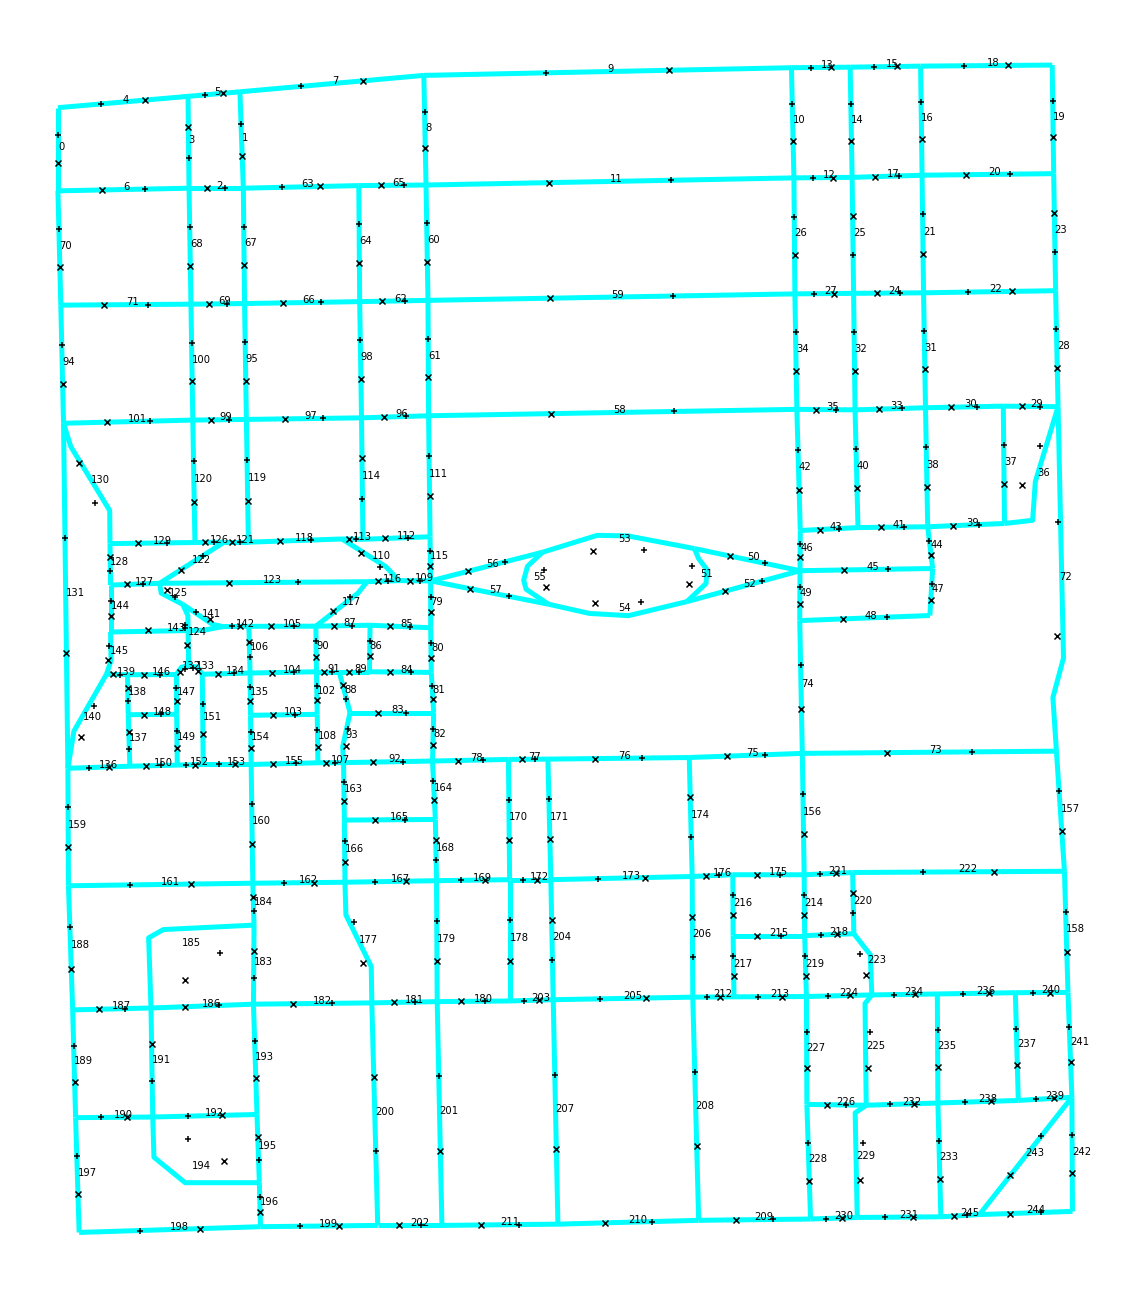

In [59]:
DATA_PATH = "../../TrafficFlowModel/data/"
TAXI_DATA_PATH = "../../TrafficFlowModel/data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

df_plot=df_edges[:246]#.append(df_edges[155+246:246+246])

ax=df_plot.plot(color="cyan", linewidth=5, figsize=(20, 30))
ax.set_axis_off()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")
    
for index, row in df_plot.iterrows():
    l=len(row.geometry.coords)
    ls=np.linspace(row.geometry.coords[0], row.geometry.coords[-1], 4)
    s = ls[1]
    e = ls[2]
    plt.scatter(s[0], s[1], marker='+', color='black', zorder=2)
    plt.scatter(e[0], e[1], marker='x', color='black', zorder=2)

plt.show();

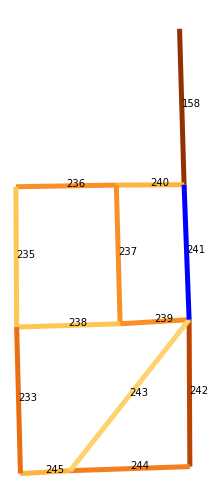

In [23]:
# case 3

DATA_PATH = "../../TrafficFlowModel/data/"
TAXI_DATA_PATH = "../../TrafficFlowModel/data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

def get_color(row):
    row["color"]=colormap(row.cor)
    return row

df_edges["cor"]=cor_matrix[n]
df_edges=df_edges.apply(get_color, axis=1)
df_edges.at[n, "color"]=(0, 0, 1, 1)

# roads=[146, 132, 133, 134, 138, 147, 151, 135, 137, 148, 149, 154, 150, 152, 153, 136, 104, 159, 94, 131]
roads=[158, 242, 240, 236, 237, 235, 239, 238, 244, 245, 233, 243, 241]
n=roads[-1]

df_plot=df_edges.iloc[roads]

ax=df_plot.plot(color=df_plot.color, linewidth=5, figsize=(16, 9))
# norm = plt.Normalize(vmin=0, vmax=1)
# n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
# n_cmap.set_array([])
# ax.get_figure().colorbar(n_cmap, fraction=0.02)
ax.set_axis_off()
# ax.plot()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")
    
# for index, row in df_plot.iterrows():
#     l=len(row.geometry.coords)
#     ls=np.linspace(row.geometry.coords[0], row.geometry.coords[-1], 4)
#     s = ls[1]
#     e = ls[2]
#     plt.scatter(s[0], s[1], marker='+', color='black', zorder=2)
#     plt.scatter(e[0], e[1], marker='x', color='black', zorder=2)

# plt.savefig("./images/road_correlation.png", dpi=300, bbox_inches="tight")
plt.show();